**My WWII USN Fighter Image Classifier**


This notebook scrapes pictures of the nine most important World War II USN carrier aircraft and then trains a CNN model which accurately classifies them.

In [2]:
from pathlib import Path
path = Path().cwd()/"warbirds" #assigns path to current working directory

#These classes need to be in alphabetical order:
warbirds = ['avenger', 'bearcat', 'buffalo', 'corsair', 'dauntless', 'devastator', 'hellcat', 'helldiver', 'wildcat']

Many of these carrier planes look similar to each other (see pics below). For example, they are usually colored some shade of blue. They are all single-engine monoplane naval aircraft from the same navy and same timeframe.

In particular, many of the fighter aircraft can appear similar even to a human:

-The **F2A Buffalo** looks much tubbier than any of the others, but still looks similar to the **F4F Wildcat** from some angles.

-The **F4F Wildcat** looks very similar to its successor the **F6F Hellcat**. I expect the model to confuse these two the most frequently.

-The **F6F Hellcat** looks similar to its own successor the **F8F Bearcat**.

# Data collection (DuckDuckGo image scraping):

In [36]:
#import the image scraper by @JoeDockrill, website: https://joedockrill.github.io/blog/2020/09/18/jmd-imagescraper-library/
!pip install -q jmd_imagescraper
from jmd_imagescraper.core import * 
from jmd_imagescraper.imagecleaner import *

num_images = 300 #Total number of images per class we are scraping

In [37]:
#Scrape images; these commands do not necessarily need to be in alphabetical order because they produce the same folder structure regardless.
duckduckgo_search(path,"avenger","tbf avenger",max_results=num_images);
duckduckgo_search(path,"bearcat","f8f bearcat",max_results=num_images);
duckduckgo_search(path,"buffalo","f2a buffalo",max_results=num_images);
duckduckgo_search(path,"corsair","f4u corsair",max_results=num_images);
duckduckgo_search(path,"dauntless","sbd dauntless",max_results=num_images);
duckduckgo_search(path,"devastator","tbd devastator",max_results=num_images);
duckduckgo_search(path,"hellcat","f6f hellcat",max_results=num_images);
duckduckgo_search(path,"helldiver","sb2c helldiver",max_results=num_images);
duckduckgo_search(path,"wildcat","f4f wildcat",max_results=num_images);


Duckduckgo search: tbf avenger


Duckduckgo search: f8f bearcat


Duckduckgo search: f2a buffalo


Duckduckgo search: f4u corsair


Duckduckgo search: sbd dauntless


Duckduckgo search: tbd devastator


Duckduckgo search: f6f hellcat


Duckduckgo search: sb2c helldiver


Duckduckgo search: f4f wildcat


['/content/warbirds/avenger/001_a880194e.jpg']


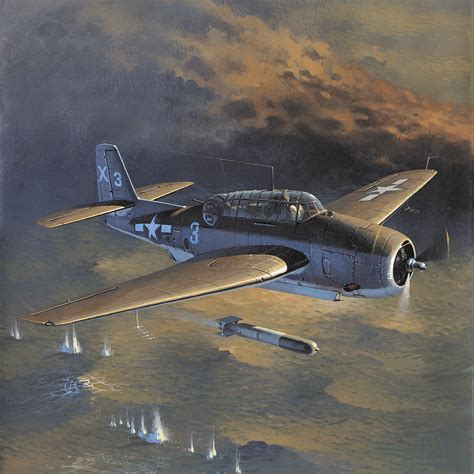

/content/warbirds/avenger/001_a880194e.jpg
['/content/warbirds/bearcat/001_f88e1113.jpg']


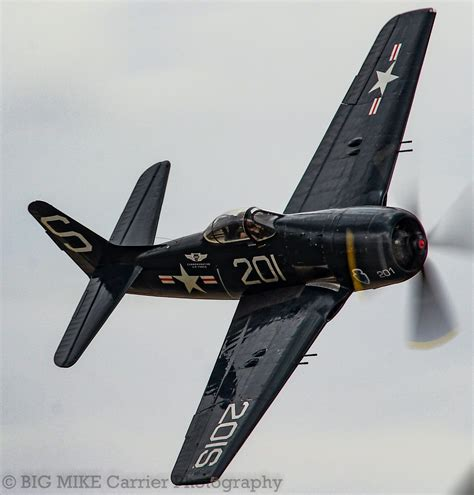

/content/warbirds/bearcat/001_f88e1113.jpg
['/content/warbirds/buffalo/001_8ee38e1c.jpg']


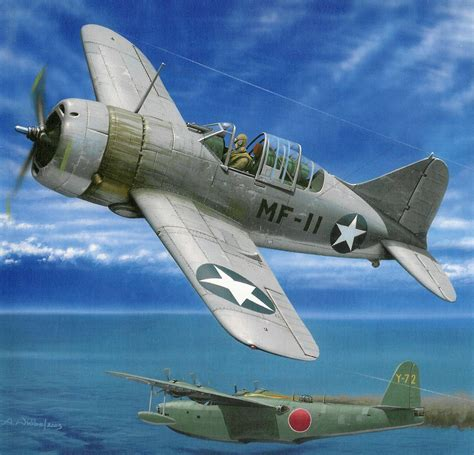

/content/warbirds/buffalo/001_8ee38e1c.jpg
['/content/warbirds/corsair/001_2d47ceee.jpg']


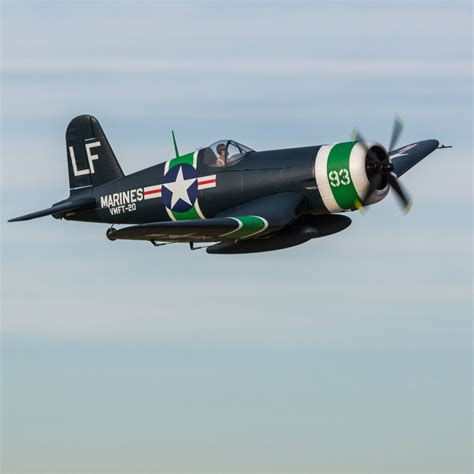

/content/warbirds/corsair/001_2d47ceee.jpg
['/content/warbirds/dauntless/001_8056f243.jpg']


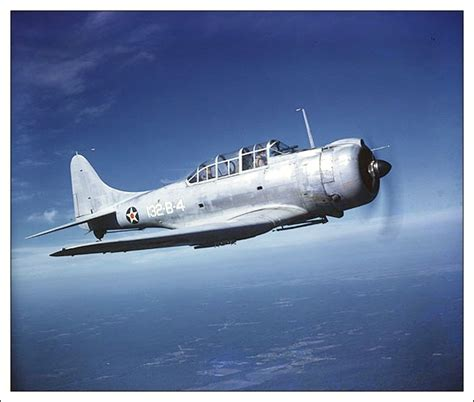

/content/warbirds/dauntless/001_8056f243.jpg
['/content/warbirds/devastator/001_8b628c6e.jpg']


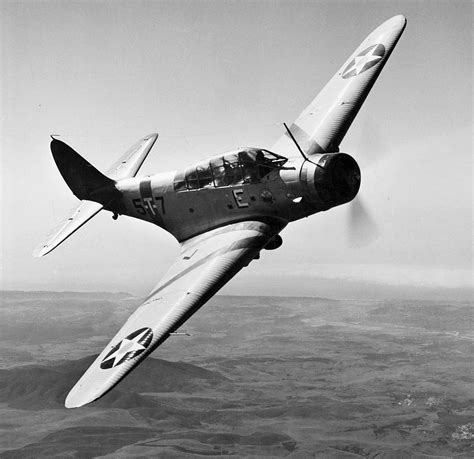

/content/warbirds/devastator/001_8b628c6e.jpg
['/content/warbirds/hellcat/001_d039a1f4.jpg']


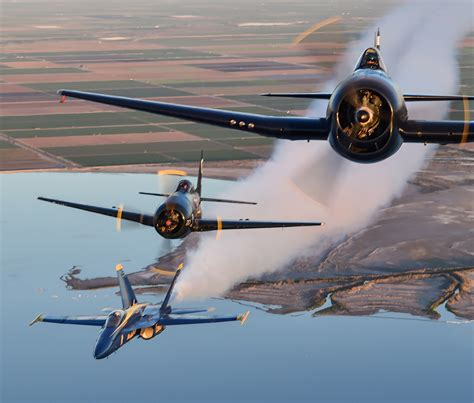

/content/warbirds/hellcat/001_d039a1f4.jpg
['/content/warbirds/helldiver/001_7c03590b.jpg']


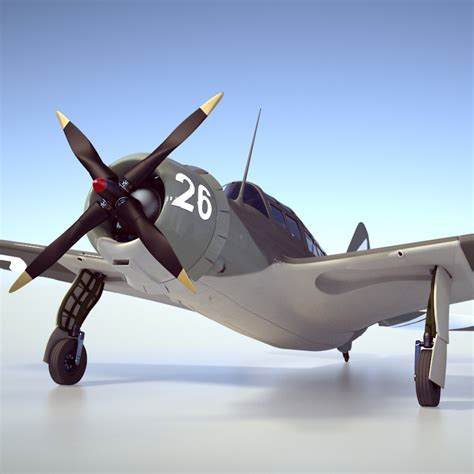

/content/warbirds/helldiver/001_7c03590b.jpg
['/content/warbirds/wildcat/001_35602dc5.jpg']


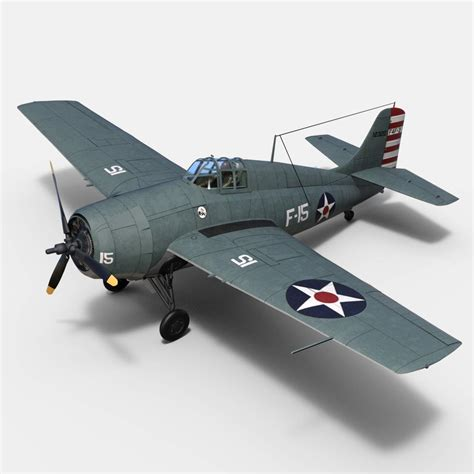

/content/warbirds/wildcat/001_35602dc5.jpg


In [34]:
#Display one image of each aircraft type:
import glob
from IPython.display import Image, display

file_type = "/*.jpg"
src_path = str(path) #warbirds folder
num_imgs = 1

def display_n_images(src_path, file_type, num_images):
    for warbird in warbirds:  
        image_folder = glob.glob(src_path + "/" + warbird + file_type) # glob will return list of jpg images
        print(image_folder)
        image_folder = image_folder[0:num_imgs] # splitting list
        for img in image_folder:
            display(Image(filename=img))
            print(img)
            
display_n_images(src_path, file_type, no_of_image_to_show)

In [ ]:
#Download all the scraped pictures, if desired:
!zip -r /content/aircraft_pics2.zip /content

from google.colab import files
files.download("/content/aircraft_pics2.zip");

In [29]:
#Upload my own preprocessed images, for convenience:
#(open zip file in colab to extract it first)
from zipfile import ZipFile
file_name = '/content/warbirds_processed.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
#@title Code to delete pictures in case you mess up:
#Utility code to delete folders if necessary:
import shutil
#shutil.rmtree('/content/warbirds')
#shutil.rmtree('/content/warbirds_processed')

# Data Cleaning (Remove incorrect images and near-duplicates)

In [38]:
#Image cleaner provided by jmd_imagescraper
#Manually search thru images to delete wrong examples:
display_image_cleaner(path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [ ]:
#AUTOMATIC IMAGE CLEANING using FIFTYONE:
!pip install fiftyone
!pip install torch torchvision
!pip install sklearn
import fiftyone as fo
import fiftyone.zoo as foz
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

#Create fiftyone model:
dataset = fo.Dataset.from_dir(path, dataset_type=fo.types.ImageClassificationDirectoryTree)
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings = dataset.compute_embeddings(model)
print(embeddings.shape)

similarity_matrix = cosine_similarity(embeddings)
print(similarity_matrix.shape)
print(similarity_matrix)

#Every single picture is a perfect match with itself, but we want to ignore that fact.
#So we subtract the  identity matrix from similarity matrix so main diagonal values are 0 instead of 1:
n = len(similarity_matrix)
similarity_matrix = similarity_matrix - np.identity(n)

id_map = [s.id for s in dataset.select_fields(["id"])]
#filepath_map = [f.filepath for f in dataset.select_fields(["filepath"])]
for idx, sample in enumerate(dataset):
    sample["max_similarity"] = similarity_matrix[idx].max()
    sample.save()

In [ ]:
#Look at image data via FIFTYONE applet, sorted by max_similartiy (descending)
view = dataset.sort_by("max_similarity", True)
session = fo.launch_app(view=view)

In [ ]:
#Remove "similar" images using FIFTYONE, based on a threshold:
import os

#Similarity threshold parameter:
thresh = 0.91

samples_to_remove = set()
samples_to_keep = set()

for idx, sample in enumerate(dataset):
    if sample.id not in samples_to_remove:
        # Keep the first instance of two duplicates
        samples_to_keep.add(sample.id)
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        for dup in dup_idxs:
            # We kept the first instance so remove all other duplicates
            samples_to_remove.add(id_map[dup])
        if len(dup_idxs) > 0:
            sample.tags.append("has_duplicates")
            sample.save()
    else:
        sample.tags.append("duplicate")
        sample.save()
dataset.remove_samples(list(samples_to_remove))

# If you want to remove the samples from the dataset entirely 
"""
#dataset.delete_samples(list(samples_to_remove))
#print(filepaths_to_remove)
#            os.remove(filepath_map[dup])
#for filepath in filepaths_to_remove:
#    os.remove(filepath)
#print(filepaths_to_remove)
"""

In [ ]:
#@title Alternative: use FastAI images cleaner instead
#Or if you prefer you can use FastAI's cleaner instead; it takes a long time to load the images though.
#Also, properly importing these libraries may require a runtime restart in Colab!
"""
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

files = get_image_files(path)
w = ImagesCleaner(max_n=400)
w.set_fns(files)
w
"""

# Set aside some data for Validation and Training sets:

In [ ]:
#Splitfolders takes random samples and places them in separate train and test folders:
!pip install split_folders
import splitfolders
input_folder = "/content/warbirds"
output_folder = "/content/warbirds_processed"

#ratio is train/val/test:
splitfolders.ratio(input_folder, output_folder, seed=22, ratio=(0.7,0.15,0.15))

Copying files: 2278 files [00:00, 5804.20 files/s]


In [ ]:
#@title Alternative: Manually split data into train/test folders
#CODE TO MANUALLY SELECT A RANDOM SAMPLE TO SEND TO THE TESTING FOLDER;
#(KERAS DOES NOT PROVIDE A WAY TO EASILY SPLIT TRAINING AND TESTING DATA FOR SOME REASON)
"""
os.mkdir('/content/warbirds_processed')
os.mkdir('/content/warbirds_processed/bearcat')
os.mkdir('/content/warbirds_processed/buffalo')
os.mkdir('/content/warbirds_processed/corsair')
os.mkdir('/content/warbirds_processed/hellcat')
os.mkdir('/content/warbirds_processed/wildcat')

import numpy as np
import os

folders = ['bearcat', 'buffalo', 'corsair', 'hellcat', 'wildcat']
for folder in folders:
  # list all files in dir
  files = [f for f in os.listdir('/content/warbirds/' + folder)]
  # select 0.15 of the files randomly 
  random_files = np.random.choice(files, int(len(files)*.15), replace=False)
  source = '/content/warbirds/' + folder
  for num, random_file in enumerate(random_files):
    os.replace(source + "/"+ random_file,"/content/warbirds_processed" + "/" + folder + random_file)
"""

# Building the model:

In [39]:
train_data_dir = "/content/warbirds_processed/train"
valid_data_dir = "/content/warbirds_processed/val"
test_data_dir = "/content/warbirds_processed/test"

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [42]:
#Params:
img_height, img_width = (224,224)
batch_size = 32
num_epochs = 14
num_dense = 1024 #First layer complexity, 1024
lr = 0.0015 #default for Adam is 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

#Optional: Learning Rate Scheduler
"""
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
"""

'\nlr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(\n    initial_learning_rate=1e-2,\n    decay_steps=10000,\n    decay_rate=0.9)\nopt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)\n'

In [43]:
#Create data generators and show classes:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.1,
                                   rotation_range = 10,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split = 0.4)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training")

valid_generator= datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation")

test_generator= datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1, #in order to test one at a time
    class_mode="categorical",
    subset="validation")

#train_generator.classes

Found 951 images belonging to 9 classes.
Found 131 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


#Last minute check on our data before we train:

In [44]:
#Verify image and class list tensor shapes:
x,y = test_generator.next()
x.shape, y.shape, train_generator.num_classes

((1, 224, 224, 3), (1, 9), 9)

In [45]:
#Create the base CNN:
res_model = ResNet50(include_top=False, weights='imagenet',classes=train_generator.num_classes, input_shape=(img_height, img_width, 3)) #input_tensor=None

#Add dense layers at front and softmax at end for prediction/classification:
x = res_model.output
x = GlobalAveragePooling2D()(x) #puts another layer in front of x
x = Dense(num_dense, activation='relu')(x) #""
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

#Freeze CNN layers to non-trainable (we don't want to train these!):
for layer in res_model.layers:
  layer.trainable = False

model = Model(inputs=res_model.input, outputs=predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#@title Code Graveyard for alternative models/architectures:
#(Xception, etc)
"""
res_model = ResNet50(include_top=False, weights='imagenet')
x = res_model.output
x = GlobalAveragePooling2D()(x) #puts another layer in front of x
x = Dense(num_dense, activation='relu')(x) #""
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=res_model.input, outputs=predictions)
for layer in res_model.layers:
  layer.trainable = False

#############################################################

#NEW
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height,img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(img_height,img_width, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
#x = inputs

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

############################################################

pretrained_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3), include_top=False, pooling='avg') #classes=train_generator.num_classes

# Freeze the base_model
for layer in pretrained_model.layers:
  layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(num_dense, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(train_generator.num_classes, activation='softmax'))
"""

In [46]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #optimizer='adam'

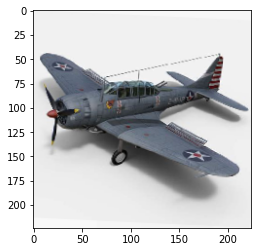

In [ ]:
#Show example image (using tensorflow):
#(It looks a little brighter than the PIL image)
x,y = test_generator.next()
from PIL import Image
from tensorflow.keras.preprocessing import image
import tensorflow.keras.utils
img = x[0,:,:]
img.shape
img = tf.keras.preprocessing.image.array_to_img(img)
plt.imshow(img)
plt.show()

#Show example image using Pillow:
#(if there's a dimension error run this cell again to look at the next photo):
"""
x,y = test_generator.next()
from PIL import Image
#from tensorflow.keras.preprocessing import image
for i in range(0,1):
  image = x[i]
  #print(image)
  plt.imshow(np.array(image, dtype=np.int32))
  plt.show()
y
"""


In [ ]:
#['avenger', 'bearcat', 'buffalo', 'corsair', 'dauntless', 'devastator', 'hellcat', 'helldiver', 'wildcat']
y

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

#Compile, Train and Save model:

In [47]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#Train the model on the training data:
train_history = model.fit(train_generator, epochs=num_epochs, validation_data = valid_generator, verbose=2)

Epoch 1/14
30/30 - 190s - loss: 2.4563 - accuracy: 0.2008 - val_loss: 1.9798 - val_accuracy: 0.3130
Epoch 2/14
30/30 - 180s - loss: 1.7849 - accuracy: 0.3607 - val_loss: 1.8258 - val_accuracy: 0.3511
Epoch 3/14
30/30 - 180s - loss: 1.5512 - accuracy: 0.4669 - val_loss: 1.7598 - val_accuracy: 0.3588
Epoch 4/14
30/30 - 181s - loss: 1.3703 - accuracy: 0.5405 - val_loss: 1.7807 - val_accuracy: 0.3969
Epoch 5/14
30/30 - 182s - loss: 1.2522 - accuracy: 0.5857 - val_loss: 1.6584 - val_accuracy: 0.4198
Epoch 6/14
30/30 - 182s - loss: 1.1301 - accuracy: 0.6099 - val_loss: 1.7834 - val_accuracy: 0.4580
Epoch 7/14
30/30 - 179s - loss: 1.0894 - accuracy: 0.6341 - val_loss: 1.7115 - val_accuracy: 0.4351
Epoch 8/14
30/30 - 184s - loss: 0.9521 - accuracy: 0.6835 - val_loss: 1.7850 - val_accuracy: 0.4733
Epoch 9/14
30/30 - 182s - loss: 0.8532 - accuracy: 0.7192 - val_loss: 1.5714 - val_accuracy: 0.5191
Epoch 10/14
30/30 - 182s - loss: 0.8346 - accuracy: 0.7382 - val_loss: 1.6504 - val_accuracy: 0.5038

In [ ]:
model.save("/content/warbirds/ResNet50_Warbirds.hdf5");

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Calculating and visualizing accuracy: 

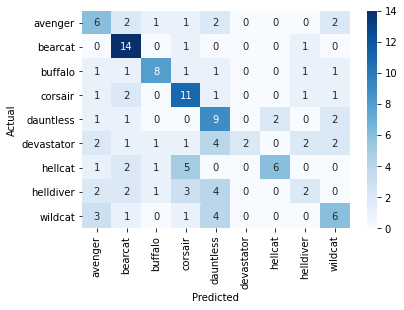

In [ ]:
#Confusion Matrix
#tutorial which helped me: https://www.youtube.com/watch?v=1Gbcp66yYX4
import pandas as pd
import seaborn as sn

model = tf.keras.models.load_model("/content/warbirds/ResNet50_Warbirds.hdf5")
filenames = test_generator.filenames
samples_num = len(test_generator) # len(warbirds)
y_prob = []
y_act = []
test_generator.reset()

for i in range(samples_num):
  X_test, Y_test = test_generator.next()
  result = model.predict(X_test)
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)
  res = result[0]
  res.sort()
  res = res[::-1]
  prob = res[:3]

predicted_class = [list(train_generator.class_indices.keys())[j.argmax()] for j in y_prob]
actual_class = [list(train_generator.class_indices.keys())[j.argmax()] for j in y_act]
out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()

In [ ]:
X, Y = test_generator.next()
result = model.predict(X)
#result.sort()
result = result[::-1] #reverses list
result, list(train_generator.class_indices.keys())[result.argmax()], list(train_generator.class_indices.keys())[Y.argmax()]

(array([[0.13180555, 0.05925404, 0.2302719 , 0.20425162, 0.2547761 ,
         0.00081752, 0.04426934, 0.02949072, 0.0450632 ]], dtype=float32),
 'dauntless',
 'buffalo')

In [ ]:
model.evaluate(X_test, Y_test)

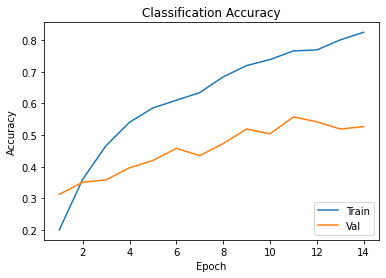

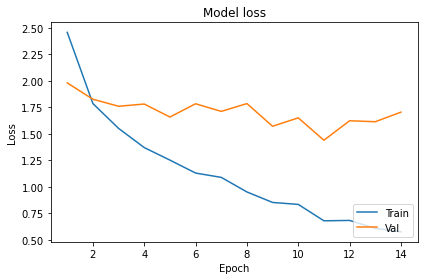

In [ ]:
#Plot accuracy/loss vs epochs for train/validation datasets:

#Accuracy:
epoch_range = range(1, num_epochs+1)
plt.plot(epoch_range, train_history.history['accuracy'])
plt.plot(epoch_range, train_history.history['val_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

#Loss
plt.plot(epoch_range,train_history.history['loss'])
plt.plot(epoch_range, train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.tight_layout()

# New Section

In [ ]:
#Improve:
#Grid search
#Cross validation